# 4.3

In [1]:
import pandas as pd
vocab = []
with open('hw4_vocab.txt') as f:
    for line in f.readlines():
        vocab.append(line[:-1])

In [2]:
unigrams = []
with open('hw4_unigram.txt') as f:
    for line in f.readlines():
        unigrams.append(int(line))

In [3]:
df = pd.DataFrame({'word': vocab, 'unigrams': unigrams}, columns=['word', 'unigrams'])

In [4]:
df['unigram_probs'] = df['unigrams'] / df['unigrams'].sum()

## 4.3 a)

In [5]:
df[df['word'].str.startswith('M')]

,word,unigrams,unigram_probs
53,MILLION,169479,0.002073
68,MORE,139728,0.001709
76,MR.,117873,0.001442
120,MOST,64424,0.000788
121,MARKET,63807,0.000780
125,MAY,59680,0.000730
129,M.,57514,0.000703
130,MANY,56968,0.000697
158,MADE,45777,0.000560
177,MUCH,42076,0.000515


## 4.3 b)

In [6]:
with open('hw4_bigram.txt') as f:
    bigrams = pd.read_csv(f, sep='\t', header=None, names=['First', 'Second', 'Count'])

In [7]:
# bigrams['bigram_prob'] = bigrams['Count'] / bigrams['Count'].sum()
# bigrams['First'].apply(lambda x: x['Count'] / df.iloc[x['First']-1][unigrams])
p = []
for _, row in bigrams.iterrows():
    p.append(row['Count'] / df.iloc[row['First']-1]['unigrams'])
bigrams['bigram_prob'] = p

In [8]:
index = df[df['word']=='THE'].index[0] + 1

In [9]:
the_bigrams = bigrams[bigrams['First']==index]
the_bigrams = the_bigrams.sort_values('bigram_prob', ascending=False)
the_bigrams = the_bigrams.head(n=10)

In [10]:
for _, row in the_bigrams.iterrows():
    word = df.iloc[int(row['Second']) - 1]
    print("Word: {}, Probablity: {}".format(word['word'], row['bigram_prob']))

Word: <UNK>, Probablity: 0.6150198100055118
Word: U., Probablity: 0.013372499432610317
Word: FIRST, Probablity: 0.011720260675031612
Word: COMPANY, Probablity: 0.011658788055636611
Word: NEW, Probablity: 0.009451480076516552
Word: UNITED, Probablity: 0.008672308141231398
Word: GOVERNMENT, Probablity: 0.006803488635995202
Word: NINETEEN, Probablity: 0.006650714911000876
Word: SAME, Probablity: 0.006287066757449016
Word: TWO, Probablity: 0.006160749602827221


## 4.3 c)

In [19]:
import numpy as np
def lookup_word(word):
    return df.loc[df['word'] == word].index[0] + 1

def compute_mle_uni(text):
    text = text.upper().split()
    p = df[df['word'].isin(text)]['unigram_probs'].product()
    return np.log(p)

def compute_mle_bi(text):
    text = text.upper().split()
    text.insert(0, "<s>")
    P = 1
    for i in range(len(text) - 1):
        first_index = lookup_word(text[i])
        second_index = lookup_word(text[i+1])
        p = bigrams[(bigrams['First']==first_index) & (bigrams['Second']==second_index)]['bigram_prob']
        if p.empty:
            print("Not found: {} {}".format(text[i], text[i+1]))
            p = 0
        else:
            p = float(p)
        P *= p
    return np.log(P)



In [20]:
sentence = "The stock market fell by one hundred points last week"
print(sentence)
result = compute_mle_uni(sentence)
print("MLE Unigram: {}".format(result))
result = compute_mle_bi("The stock market fell by one hundred points last week")
print("MLE Bigram: {}".format(result))

The stock market fell by one hundred points last week
MLE Unigram: -64.50944034364878
MLE Bigram: -40.91813213378977


Bigram model yields a higher log likelihood.

## 4.3 d)

In [21]:
sentence = "The sixteen officials sold fire insurance"
print(sentence)
result = compute_mle_uni(sentence)
print("MLE Unigram: {}".format(result))
result = compute_mle_bi("The sixteen officials sold fire insurance")
print("MLE Bigram: {}".format(result))

The sixteen officials sold fire insurance
MLE Unigram: -44.291934473132606
Not found: SIXTEEN OFFICIALS
Not found: SOLD FIRE
MLE Bigram: -inf


SIXTEEN OFFICIALS and SOLD FIRE were not found in bigram corpus. The log-likelihood of the sentence is negative infinity since we never encountered the two bigrams in our corpus and assume they never occur together.

## 4.3 e)

In [22]:
def compute_mle_mixture(text, lam):
    text = text.upper().split()
    text.insert(0, "<s>")
    p = 1
    for i in range(len(text) - 1):
        p_uni = float(df[df['word'] == text[i+1]]['unigram_probs'])
        first_index = lookup_word(text[i])
        second_index = lookup_word(text[i+1])
        p_bi = bigrams[(bigrams['First']==first_index) & (bigrams['Second']==second_index)]['bigram_prob']
        if p_bi.empty:
            p_bi = 0
        else:
            p_bi = float(p_bi)
        p *= lam * p_uni + (1-lam) * p_bi
    return np.log(p)

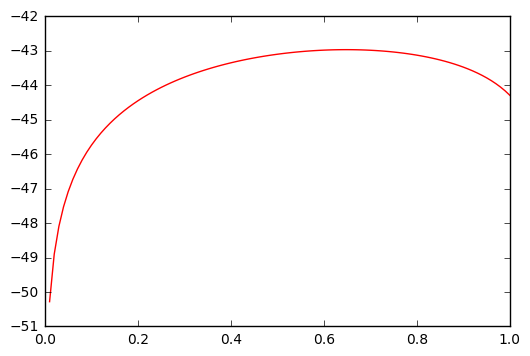

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
x = []
y = []
for i in np.linspace(0, 1, 101):
    x.append(i)
    y.append(compute_mle_mixture("The sixteen officials sold fire insurance", i))
plt.plot(x, y, 'r-')

In [26]:
print("Max log-likelihood: {}".format(max(y)))
index = y.index(max(y))
max_index = x[index]
print("Lambda for max log-likelihood: {}".format(max_index))

Max log-likelihood: -42.96416428296298
Lambda for max log-likelihood: 0.65


# 4.4

In [27]:
nasdaq2k = []
with open('hw4_nasdaq00.txt') as f:
    for line in f.readlines():
        nasdaq2k.append(float(line))

In [28]:
nasdaq2k = np.array(nasdaq2k)

In [29]:
y = nasdaq2k[3:].reshape(-1, 1)
X = np.column_stack([nasdaq2k[2:-1], nasdaq2k[1:-2], nasdaq2k[:-3]])

In [33]:
X = np.matrix(X)
y = np.matrix(y)
theta = np.linalg.inv(X.T * X) * X.T * y
print("[a1, a2, a3]= {}".format(theta))

[a1, a2, a3]= [[ 0.95067337]
 [ 0.01560133]
 [ 0.03189569]]


In [34]:
mean_squared_error = np.sum(np.square(X.dot(theta) - y)) / len(y)
mse = np.sum(np.square(X.dot(theta) - y)) / len(y)
print("MSE for year 2000: {}".format(mse))

MSE for year 2000: 13902.401076367885


In [35]:
nasdaq2k1 = []
with open('hw4_nasdaq01.txt') as f:
    for line in f.readlines():
        nasdaq2k1.append(float(line))

In [37]:
nasdaq2k1 = np.array(nasdaq2k1)
y = nasdaq2k1[3:].reshape(-1, 1)
X = np.column_stack([nasdaq2k1[2:-1], nasdaq2k1[1:-2], nasdaq2k1[:-3]])
X = np.matrix(X)
y = np.matrix(y)
mean_squared_error_2001 = np.sum(np.square(X.dot(theta) - y)) / len(y)

In [38]:
print("MSE for year 2001: {}".format(mean_squared_error_2001))

MSE for year 2001: 2985.0979241115374


I would not recommend this linear model for stock market prediction because of it's high mean squared error on the training set, which implies that it was not able to fit the training data well.